# 2-Layer Neural Network Implementation

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Process the Dataset

Load, Shuffle, Split, Normalise Dataset

In [2]:
data = pd.read_csv('data/train.csv') # Load MNIST training data (label in first column, pixels after)

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = np.array(data) # Convert to numpy array for faster computation

# m = number of examples
# n = number of features + label
m,n = data.shape

In [5]:
np.random.shuffle(data) # Shuffle data to avoid learning order bias

# Split data into development and training sets
data_dev = data[0:1000].T
data_train = data[1000:m].T

# Separate labels (Y) and features (X)
Y_dev = data_dev[0]
X_dev = data_dev[1:n]  / 255. # Values are divided by 255 to scale them between 0 and 1 - Pixel Normalization
Y_train = data_train[0]
X_train = data_train[1:n]  / 255.

## Neural Network Implementation

### Function to initialise the weights and biases for both the layers

In [6]:
# Initialize weights and biases for a 2-layer neural network.

# Layer 1: 784 -> 10 -> (ReLU)
# Layer 2: 10 -> 10 -> (Softmax)

def initialise_parameters():
    np.random.seed(1)

    # small random values for weights and for biases
    W1 = np.random.rand(10, 784)
    b1 = np.random.rand(10, 1)
    W2 = np.random.rand(10, 10)
    b2 = np.random.rand(10, 1)
    
    return W1, b1, W2, b2

### Activation functions used in layers

In [7]:
# ReLU activation: max(0, Z) i.e. z if z>0 else 0

def Relu(Z):
    return np.maximum(0, Z)

In [8]:
# Softmax activation for multi-class classification.
# Provides a probability distribution over classes and totals to 1.

def softmax(Z):
    Z = Z - np.max(Z, axis=0, keepdims=True)
    exp_scores = np.exp(Z)
    return exp_scores / np.sum(exp_scores, axis=0, keepdims=True)

### Utility functions used in calculations

In [9]:
# Convert labels into one-hot encoded vectors.
# Example: 3 -> [0,0,0,1,0,0,0,0,0,0]

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [10]:
# Derivative of ReLU for backpropagation

def derivative_Relu(Z):
    return (Z > 0).astype(float)

In [11]:
# Return predicted class labels

def get_predictions(A2):
    return np.argmax(A2, 0)

In [12]:
# Compute classification accuracy

def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

In [13]:
# Computes categorical cross-entropy loss
# A2: softmax probabilities (10, m)
# Y : true labels (m,)


def compute_loss(A2, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)

    # Add epsilon to avoid log(0)
    epsilon = 1e-8
    loss = -(1 / m) * np.sum(one_hot_Y * np.log(A2 + epsilon))
    return loss

### Forward Propagation

In [14]:
# Passing data through the network
# X -> Linear (Hidden Layer)-> ReLU -> Linear(Output Layer) -> Softmax

def forward_pass(W1, b1, W2, b2, X):
    Z1 = np.dot(W1, X) + b1
    A1 = Relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

### Backward Propagation

In [15]:
# Compute gradients using backpropagation
# dW1, db1, dW2, db2 are gradients of weights and biases
# gradients are the partial derivatives of the loss w.r.t parameters
# Loss: Cross-entropy with softmax

def backward_pass(Z1, A1, Z2, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)
    m = Y.size

    dz2 = A2 - one_hot_Y
    dW2 = (1/m) * np.dot(dz2, A1.T)
    db2 = (1/m) * np.sum(dz2, axis=1, keepdims=True)

    dz1 = np.dot(W2.T, dz2) * derivative_Relu(Z1)
    dW1 = (1/m) * np.dot(dz1, X.T)
    db1 = (1/m) * np.sum(dz1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

### Parameters Updation

In [16]:
# Update weights and biases using gradient descent and specified learning rate 

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    return W1, b1, W2, b2

### Training Loop

In [17]:
# Train the neural network using gradient descent

def gradient_descent(X, Y, iterations, learning_rate):
    # Initialize parameters
    W1, b1, W2, b2 = initialise_parameters()
    
    # Training loop
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_pass(W1, b1, W2, b2, X) # Forward pass
        dW1, db1, dW2, db2 = backward_pass(Z1, A1, Z2, A2, W2, X, Y) # Backward pass
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate) # Update parameters
        
        # Print accuracy every 20 iterations - Monitor training progress
        if i % 20 == 0:
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            loss = compute_loss(A2, Y)
            print(f"Iteration: {i} | Loss: {loss:.4f} | Accuracy: {accuracy:.4f}")
    
    return W1, b1, W2, b2

## Testing Utility Functions

In [18]:
# Run forward pass and return predictions

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_pass(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [19]:
# Predict a single image and display it

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

## Model Training and Inference

In [20]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, iterations=1000, learning_rate=0.05) # Model Training

Iteration: 0 | Loss: 15.6134 | Accuracy: 0.0901
Iteration: 20 | Loss: 16.4547 | Accuracy: 0.1037
Iteration: 40 | Loss: 8.3383 | Accuracy: 0.2726
Iteration: 60 | Loss: 3.3962 | Accuracy: 0.4849
Iteration: 80 | Loss: 1.5823 | Accuracy: 0.5558
Iteration: 100 | Loss: 1.9520 | Accuracy: 0.5876
Iteration: 120 | Loss: 1.3014 | Accuracy: 0.6235
Iteration: 140 | Loss: 1.2950 | Accuracy: 0.6556
Iteration: 160 | Loss: 1.1129 | Accuracy: 0.6815
Iteration: 180 | Loss: 1.0325 | Accuracy: 0.7011
Iteration: 200 | Loss: 1.0150 | Accuracy: 0.7120
Iteration: 220 | Loss: 1.0346 | Accuracy: 0.7082
Iteration: 240 | Loss: 0.9397 | Accuracy: 0.7278
Iteration: 260 | Loss: 0.8784 | Accuracy: 0.7407
Iteration: 280 | Loss: 0.8395 | Accuracy: 0.7500
Iteration: 300 | Loss: 0.8105 | Accuracy: 0.7572
Iteration: 320 | Loss: 0.7853 | Accuracy: 0.7648
Iteration: 340 | Loss: 0.7627 | Accuracy: 0.7710
Iteration: 360 | Loss: 0.7422 | Accuracy: 0.7767
Iteration: 380 | Loss: 0.7233 | Accuracy: 0.7826
Iteration: 400 | Loss: 0

## Testing model

Prediction:  [8]
Label:  7


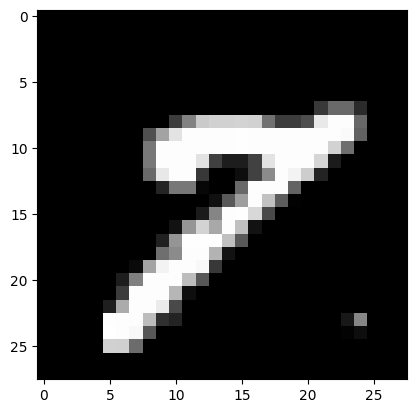

Prediction:  [2]
Label:  2


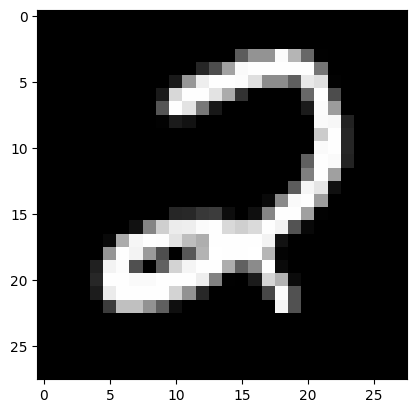

Prediction:  [1]
Label:  1


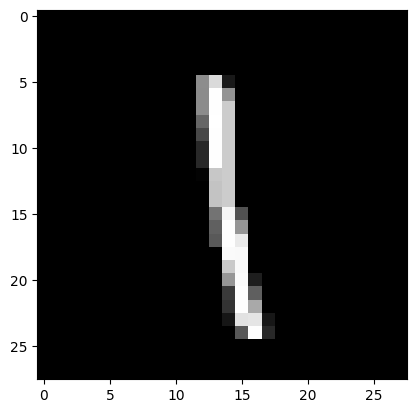

Prediction:  [0]
Label:  0


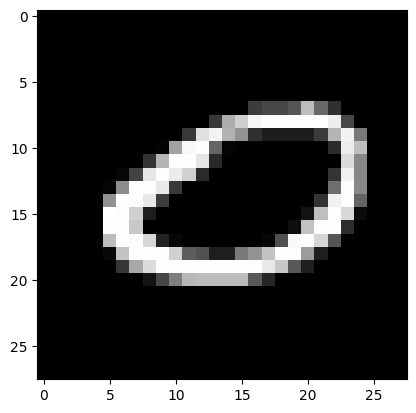

In [21]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [ ]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

np.float64(0.863)